<h3>项目介绍</h3>|
去链家爬了2万多个深圳二手房的数据，有房屋的很多信息以及房屋的价格,我们需要用这些数据训练波形来预测其他房屋的每平方售价.
1.使用numpy pandas re正则进行数据清洗和预处理；
2.使用pandas进行数据统计；
3.使用matplotlib seaborn进行数据可视化；
4.使用科学计算包sklearn/xgboost，对清洗后的数据进行建模前的数据标准化,测试集数据集的切分,建模预测,模型效率指标的计算。


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy import stats

<h4>初始化seaborn包</h4>

In [2]:
def sns_init():
    sns.set()
    sns.set_palette("Set1")
    plt.rcParams['font.family'] = ['Arial Unicode MS'] #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
    plt.rc('figure', dpi=100)
sns_init()

<h4>载入数据，同时对数据列名重命名</h4>

In [3]:
df = pd.read_csv('lianjia_secondhand.csv',header=None)
df.rename(columns={0:'key', 1:'id', 2:'房屋户型',3:'所在楼层',4:'建筑面积',5:'户型结构',6:'套内面积',7:'建筑类型',8:'房屋朝向',9:'建筑结构',10:'装修情况',11:'梯户比例',12:'配备电梯',13:'产权年限',14:'挂牌时间',15:'交易权属',16:'上次交易',17:'房屋用途',18:'房屋年限',19:'产权所属',20:'抵押信息',21:'房本备件',22:'房协编码',23:'房间数',24:'楼层情况',25:'朝向',26:'装修',27:'平方米',28:'建筑年代/类型',29:'所在区域',30:'近30天带看人数',31:'总价格',32:'每平方售价',33:'小区名字',34:'经度',35:'纬度',36:'title1',37:'title2',38:'url'}, inplace = True)

In [4]:
pd.set_option('display.max_columns', None) #不忽略所有列
df.head(1) #查看数据内容

,key,id,房屋户型,所在楼层,建筑面积,户型结构,套内面积,建筑类型,房屋朝向,建筑结构,装修情况,梯户比例,配备电梯,产权年限,挂牌时间,交易权属,上次交易,房屋用途,房屋年限,产权所属,抵押信息,房本备件,房协编码,房间数,楼层情况,朝向,装修,平方米,建筑年代/类型,所在区域,近30天带看人数,总价格,每平方售价,小区名字,经度,纬度,title1,title2,url
0,1,105100491687,2室1厅1厨1卫,高楼层 (共25层),67.24㎡,平层,暂无数据,板塔结合,南,钢混结构,简装,三梯八户,有,70年,2016-11-04,商品房,2016-02-17,普通住宅,满两年,非共有,有抵押 200万元 业主实收，客户还款 客户偿还,已上传房本照片,U177825501660,2室1厅,高楼层/共25层,南,平层/简装,67.24平米,2003年建/板塔结合,罗湖区,2,420.0,62463,嘉宝田花园,114.1176,22.5641,"['客厅', '22.96平米', '西', '普通窗', '卧室A', '8.89平米',...","['嘉宝田花园两房', '朝南楼层适中', '诚心出售']",https://sz.lianjia.com/ershoufang/105100491687...


<p>定义一个统计缺失值的函数，统计数据缺失情况。</p>
<p>1.可以看到其中3个列的缺失值均为164行，猜测为同一行。</p>
<p>2.房协编码缺失值较多，为31.7%，通过对其数据查看，发现为房子的唯一标示码，对价格并不影响，直接删除。</p>
<p>3.对剩余的缺失值进行查看，发现均为别墅类型，该数据分析主要分析深圳民用房的价格影响因素，因此可直接删除掉该类型数据。</p>

In [5]:
def missing_values_table(df):    
        # 总缺失情况
        mis_val = df.isnull().sum()
        # 缺失百分比
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        # 创建一个表格来查看缺失情况
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        # 重命名列名
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        # 按顺序排序缺失值
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
    
missing_values_table(df)

Your selected dataframe has 39 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
房协编码,6513,31.7
户型结构,164,0.8
建筑类型,164,0.8
配备电梯,164,0.8


In [6]:
df.loc[df['户型结构'].isnull(),:]['房屋用途'].unique()

array(['别墅'], dtype=object)

In [7]:
df = df.loc[df['户型结构'].notnull(),:]
df.drop('房协编码',axis=1,inplace=True)

**<p>再次查看缺失值情况，已无np.nan类型的缺失值。</p>**

In [8]:
missing_values_table(df)

Your selected dataframe has 38 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


**<p>定义个resumetable函数，用来查看数据的整体分布情况。包括数据类型，纬度，数据构成内容等情况。</p>**
<p>1.虽然我们前期去除了缺失值，但是可见部分纬度里，有取值为“暂无数据”/”无“/”未知“的，该类数据其实也是缺失的值。</p>

In [9]:
#描绘数据
def resumetable(df,count=10): #count为int类型，当某纬度去重后的取值小于等于count时，则显示出来该纬度的具体取值情况。
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    content = ""
    for i in summary[summary['Uniques']<=count]['Name']:
        content += str(i) +':'+ str(df[i].unique()) +'\n'
    print(content)
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 
    return summary

resumetable(df)

Dataset Shape: (20365, 38)
户型结构:['平层' '暂无数据' '复式' '错层' '跃层' 'Loft']
建筑类型:['板塔结合' '塔楼' '板楼' '暂无数据' '平房']
建筑结构:['钢混结构' '框架结构' '砖混结构' '钢结构' '混合结构' '未知结构' '砖木结构']
装修情况:['简装' '精装' '其他' '毛坯']
配备电梯:['有' '无' '暂无数据']
产权年限:['70年' '50年' '未知' '40年' '30年']
交易权属:['商品房']
房屋用途:['普通住宅' '公寓' '商务公寓' '商业办公类' '商住两用']
房屋年限:['满两年' '满五年' '未满两年' '暂无数据']
产权所属:['非共有' '共有']
房本备件:['已上传房本照片' '未上传房本照片']
所在区域:['罗湖区' '福田区' '南山区' '盐田区' '宝安区' '龙岗区' '龙华区' '光明区' '坪山区' '大鹏新区']



,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,key,int64,0,20365,1,2,3,14.31
1,id,int64,0,20365,105100491687,105103204743,105103293163,14.31
2,房屋户型,object,0,198,2室1厅1厨1卫,1室1厅1厨1卫,2室1厅1厨1卫,4.00
3,所在楼层,object,0,171,高楼层 (共25层),低楼层 (共33层),高楼层 (共26层),6.47
4,建筑面积,object,0,9246,67.24㎡,46.19㎡,67.55㎡,12.71
5,户型结构,object,0,6,平层,平层,平层,0.89
6,套内面积,object,0,6270,暂无数据,33.68㎡,暂无数据,8.30
7,建筑类型,object,0,5,板塔结合,板塔结合,板塔结合,1.34
8,房屋朝向,object,0,82,南,北,北,3.03
9,建筑结构,object,0,7,钢混结构,钢混结构,钢混结构,0.50


<h3>1.按顺序开始分别对逐个纬度进行数据清洗</h3>
<h5>1.1“房屋户型”</h5>
<p>1.“房屋户型”直接转换为额外的4个纬度：室|厅|厨|卫</p>
<p>2.查看“卫”与每平方售价的关系，可发现卫生间越多，其均价越高，不过卫生间越多，也代表该房子越可能是豪宅。</p>

In [10]:
df['室'],df['厅'],df['厨房'],df['卫'] = df['房屋户型'].apply(lambda x :re.split('室|厅|厨|卫',x)[:-1]).str
df.drop('房屋户型',axis=1,inplace=True) #删除房屋户型纬度

In [11]:
for i in ['室','厅','厨房','卫']:
    df[i] = df[i].astype(int)

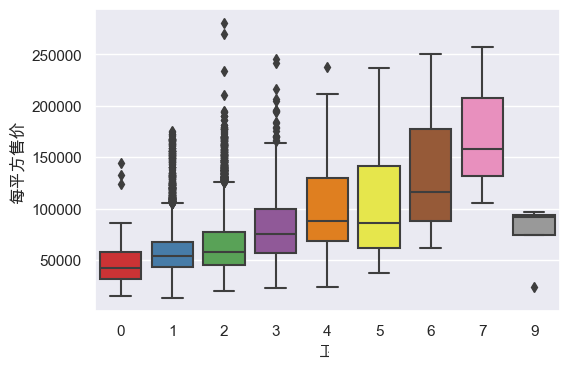

In [12]:
sns.boxplot('卫','每平方售价',data=df)

**------------------------------------------------------------------------------------------------------------------------------------------------**
<br>
<h5>1.2“所在楼层”</h5>
1.对该列的数据进行去重后，可见有个特别的值，即‘地下室 (共2层)'，且该类型只有一个，直接将该值改为‘低楼层 (共2层)’
<br>
2.同时发现其内容包含着两部分：“该房子所处的楼层高度”，“楼层数”，将该列拆分成2列。“所处楼层高度”，“总楼层数”。

In [13]:
df['所在楼层'].unique()[-10:]

array(['低楼层 (共59层)', '低楼层 (共4层)', '低楼层 (共42层)', '地下室 (共2层)', '低楼层 (共53层)',
       '低楼层 (共52层)', '中楼层 (共52层)', '高楼层 (共52层)', '中楼层 (共54层)',
       '高楼层 (共54层)'], dtype=object)

In [14]:
(df['所在楼层']=='地下室 (共2层)').sum()

1

In [15]:
df.loc[df['所在楼层']=='地下室 (共2层)','所在楼层'] = '低楼层 (共2层)' 
df['所处楼层高度'] = df['所在楼层'].apply(lambda x:x[0])
df['总楼层数'] = df['所在楼层'].apply(lambda x:int(re.search(re.compile(r'共(\d+)层'),x).group(1)))
df.drop('所在楼层',axis=1,inplace=True)

尝试将总楼层数切分成4份，分别查看其对应的平均每平方售价，发现有很强的关联性。楼房越高，其每平方售价越高。该纬度可保留

In [16]:
tmp_df = pd.DataFrame({'楼层高度':pd.cut(df['总楼层数'],4),'价格':df['每平方售价']})
tmp_df.groupby(['楼层高度'],as_index=False)['价格'].aggregate({'价格':['mean','count']})

/Users/para/anaconda3/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


楼层高度             价格       
                            mean  count
0  (0.921, 20.75]   57647.608914   8773
1   (20.75, 40.5]   64565.202324  10928
2   (40.5, 60.25]   80971.553125    640
3   (60.25, 80.0]  105425.875000     24

In [17]:
maps={'(0.921, 20.75]':1,'(20.75, 40.5]':2,'(40.5, 60.25]':3,'(60.25, 80.0]':4}
df['总楼层数区间'] = pd.cut(df['总楼层数'],4).astype(str).map(maps)
df['总楼层数区间'].value_counts()

2    10928
1     8773
3      640
4       24
Name: 总楼层数区间, dtype: int64

下面为所处楼层高度与价格的影响，低层和高层的价格相对高一点，可能这也反应人们选择居住楼层时，更偏向于低楼层的便捷性和高楼层的视野。
<br>
但总体差异不大，因该纬度仅3个分类，暂作保留

In [18]:
df.groupby(['所处楼层高度'],as_index=False)['每平方售价'].mean()

,所处楼层高度,每平方售价
0,中,61102.840230
1,低,63328.307940
2,高,62250.961196


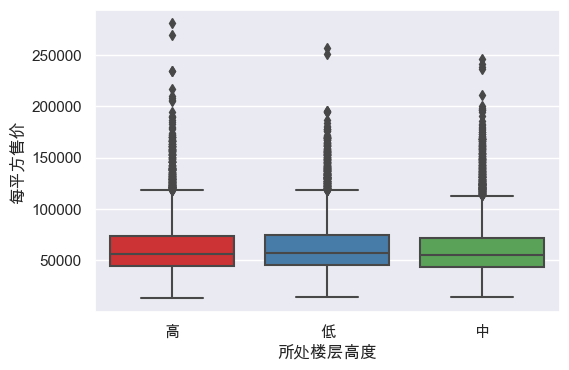

In [19]:
sns.boxplot('所处楼层高度','每平方售价',data=df)

**------------------------------------------------------------------------------------------------------------------------------------------------**
<br>
<h5>1.3“建筑面积”</h5>
1:可发现“建筑面积”为str数据格式，将数据后面的㎡去掉，转为浮点数。
<br>
2:查看该数据分布情况。可发现大部分房子集中的建筑面积在90m^2附近。
<br>
3:将建筑面积切片后，发现其区间与价格影响较大。但是其分类区间的样本数比例差异过大，95%以上的房子建筑面积在208平方米内，因此不切片将其作为连续变量分析与每平方售价的关系。
<br>

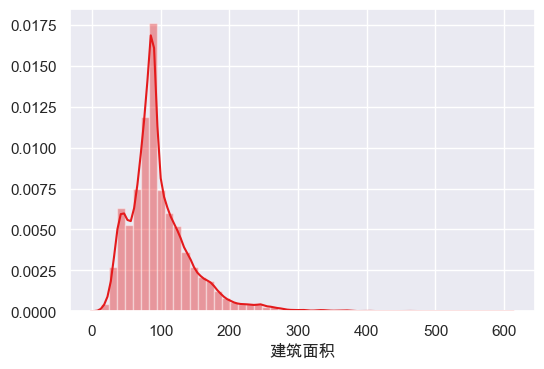

In [20]:
df['建筑面积'] = df['建筑面积'].apply(lambda x:float(x[:-1]))
sns.distplot(df['建筑面积'])

In [21]:
tmp_df = pd.DataFrame({'建筑面积':pd.cut(df['建筑面积'],3),'价格':df['每平方售价']})
tmp_df.groupby(['建筑面积'],as_index=False).agg({'价格':['mean','count']})

建筑面积             价格       
                                mean  count
0   (12.564, 208.413]   61176.339675  19763
1  (208.413, 403.677]   93123.934233    593
2   (403.677, 598.94]  156947.222222      9

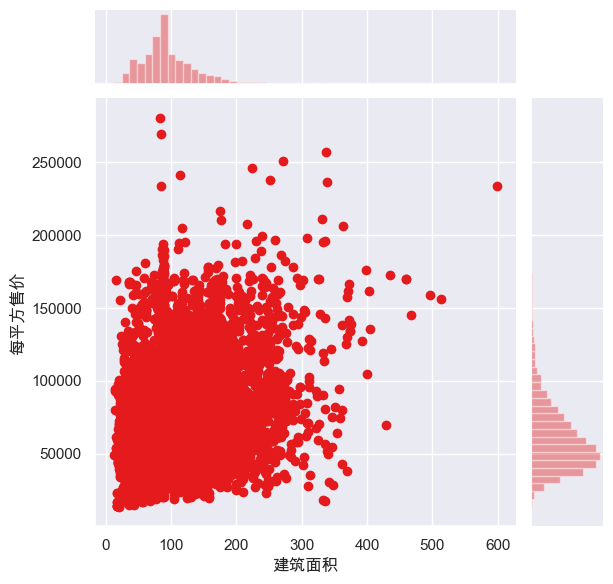

In [22]:
sns.jointplot('建筑面积','每平方售价',data=df)

In [23]:
#可以看到该批数据有个明显的异常点，即右上角建筑面积600和每平方售价20多万的点。考虑到我们分析的内容，将删去面积>=300，每平方售价>=175000的房子。异常点共计127个。
print("删除前数据:",df.shape)
print("删除后数据:",df.loc[(df['建筑面积']<300)&(df['每平方售价']<175000),:].shape)
#df.drop('建筑面积',axis=1,inplace=True)
df = df.loc[(df['建筑面积']<300)&(df['每平方售价']<175000),:]

删除前数据: (20365, 43)
删除后数据: (20238, 43)


**------------------------------------------------------------------------------------------------------------------------------------------------**
<br>
<h5>1.4“户型结构”</h5>
1.查看户型结果分布情况，可发现平层最多。而Loft仅有一列，因样本过小，删除。
<br>
2.通过箱型图查看户型与价格的影响，发现区间略有不同，该纬度暂作保留。

In [24]:
df['户型结构'].value_counts() 

平层      17065
复式       1561
暂无数据     1129
跃层        303
错层        179
Loft        1
Name: 户型结构, dtype: int64

In [25]:
df = df[df['户型结构'] != "Loft"]

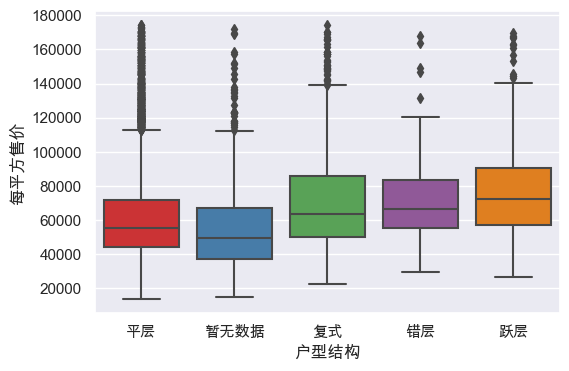

In [26]:
sns.boxplot('户型结构','每平方售价',data=df)

**------------------------------------------------------------------------------------------------------------------------------------------------**
<br>
<h5>1.5“套内面积”</h5>
1.套内面积其缺失值过多，超过40%存在缺失，且查看其数据有异常值（1㎡）。
<br>
2.可以看到套内面积与建筑面积强烈正相关，删除处理。

In [27]:
df['套内面积'].value_counts()[:5]

暂无数据      8163
1㎡          71
69.58㎡      37
27.27㎡      25
61.41㎡      19
Name: 套内面积, dtype: int64

In [28]:
df['套内面积'] =df['套内面积'].apply(lambda x : float(x[:-1]) if x!='暂无数据' else np.nan)

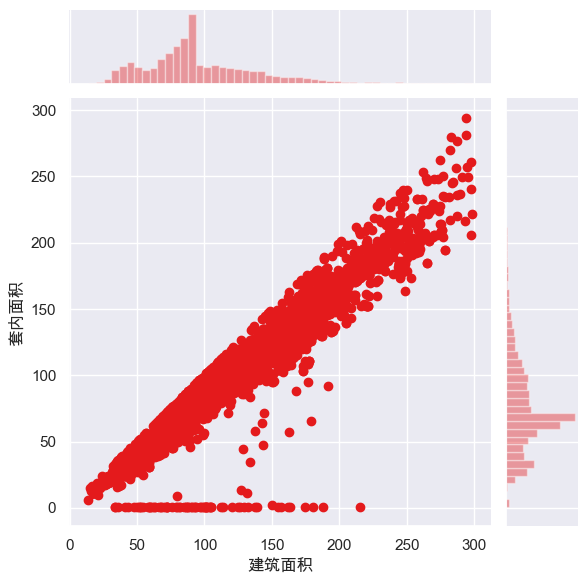

In [29]:
sns.jointplot('建筑面积','套内面积',data=df[df['套内面积'].notnull()])

In [30]:
df.drop(['套内面积'],axis=1,inplace=True)

**------------------------------------------------------------------------------------------------------------------------------------------------**
<br>
<h5>1.6“建筑类型”</h5>
1.与"户型结构"类似，暂作保留。


In [31]:
df['建筑类型'].value_counts()

板塔结合    12579
塔楼       5218
板楼       2302
暂无数据      116
平房         22
Name: 建筑类型, dtype: int64

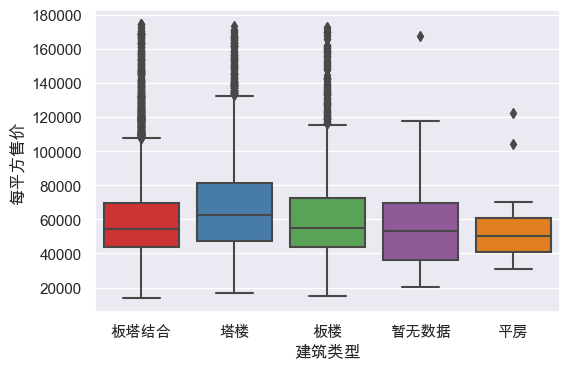

In [32]:
sns.boxplot('建筑类型','每平方售价',data=df)

**------------------------------------------------------------------------------------------------------------------------------------------------**
<br>
<h5>1.7“建筑类型”</h5>
1.房屋朝向该列去重后，仍有大量的值，考虑到实际情况，将该列转换为“是否朝南”处理。
<br>
2.发现朝向与价格的影响太小，暂作删除。

In [33]:
df['房屋朝向'].unique()

array(['南', '北', '西北', '西', '东南', '东', '东北', '西南', '南 北', '西北 东北', '东 西',
       '南 东南', '北 东北', '东 东南', '东南 西北', '北 南', '南 北 东北', '南 西', '东 南',
       '南 西南', '西南 东北', '东南 南', '东 北', '东南 东北', '西南 西北', '东南 北', '东 东南 北',
       '东 南 西', '南 东北', '东南 西南', '东 东北', '西北 东', '西 北', '西南 西', '西 西北',
       '东 南 西 北', '南 西 北', '西北 北', '西南 南', '东 南 北 东北', '东南 东', '东南 南 西南',
       '西 东', '西南 东南', '东 南 东南', '东南 南 北', '西南 北', '北 西北', '东北 东', '西 西南',
       '南 西南 东南', '南 东', '东 西 北', '东北 西南', '东 西南', '南 西北', '东 东南 南',
       '西北 东南', '东 西北', '东南 西', '南 东南 西北 北', '北 西', '东南 西北 南 北',
       '东南 西 西北', '北 东', '西北 西南', '东 东南 东北', '东南 东 南', '南 北 东南', '东北 东南',
       '西南 西北 北', '西南 北 东北', '西北 北 东北', '东南 南 东北', '东 南 北', '东南 南 西',
       '南 东 北', '西北 南', '东南 南 西北', '西 南'], dtype=object)

In [34]:
df_orientation =pd.DataFrame()
df_orientation['是否朝南'] = df['房屋朝向'].apply(lambda x:x=="南")
df_orientation['price'] = df['每平方售价']
df_orientation.groupby(['是否朝南'])['price'].mean()


是否朝南
False    61425.597273
True     62067.593439
Name: price, dtype: float64

In [35]:
df.drop('房屋朝向',axis=1,inplace=True)

**------------------------------------------------------------------------------------------------------------------------------------------------**
<br>
<h5>1.8“建筑结构”</h5>
1.与"户型结构","建筑类型"类似，暂作保留。

In [36]:
df.groupby(['建筑结构'])['每平方售价'].mean().sort_values()

建筑结构
砖混结构    51317.797619
未知结构    53416.084906
框架结构    53711.597826
混合结构    57334.840708
钢结构     59248.923077
钢混结构    62240.472264
砖木结构    63203.300000
Name: 每平方售价, dtype: float64

In [37]:
df['建筑结构'].value_counts()

钢混结构    18748
框架结构      920
砖混结构      252
混合结构      113
未知结构      106
钢结构        78
砖木结构       20
Name: 建筑结构, dtype: int64

**------------------------------------------------------------------------------------------------------------------------------------------------**
<br>
<h5>1.9“装修情况”</h5>
1.差异较为明显，精装的价格最高，符合常理。纬度保留。

In [38]:
df.groupby(['装修情况'])['每平方售价'].mean().sort_values()

装修情况
毛坯    57176.658159
简装    57518.745078
其他    61942.654314
精装    64220.347499
Name: 每平方售价, dtype: float64

**------------------------------------------------------------------------------------------------------------------------------------------------**
<br>
<h5>1.10“梯户比例”</h5>
1.数据类型为str格式，转变为float，即三梯八户=3/8，计算其梯户比。
<br>
2.查看梯户比例与每平方价格的散点图，发现大部分集中在0附近。
<br>
3.考虑到越高的梯户比，住客的体验感越好，且纬度为连续变量，暂作保留。

In [39]:
df['梯户比例'].unique()[:5]

array(['三梯八户', '三梯十四户', '三梯十二户', '两梯八户', '三梯十三户'], dtype=object)

In [40]:
df['梯户比例'].apply(lambda x : x[:-1].split('梯')[1]).unique()

array(['八', '十四', '十二', '十三', '十', '十六', '四', '十一', '三', '六', '七', '三十二',
       '十七', '十八', '两', '二十二', '五', '二十八', '二十一', '二十', '二十九', '二十四',
       '十五', '九', '二十六', '十九', '三十四', '三十九', '一', '二十五', '二十七', '二十三',
       '三十', '八十九', '一百一十三', '四十一', '五十四', '四十二', '三十一', '五十六', '四十四',
       '四十', '三十六', '九十七', '六十四', '四十三', '三十七', '一百', '六十', '五十九', '六十五',
       '五十', '四十六', '三十八', '五十一', '四十五', '三十五', '三十三'], dtype=object)

In [41]:
df['梯户比例'].apply(lambda x : x[:-1].split('梯')[0]).unique()

array(['三', '两', '一', '四', '六', '五', '八', '七', '十五', '九', '十', '十二', '十三',
       '二十', '十八'], dtype=object)

In [42]:
digit = {'一': 1, '二': 2, '两':2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9}
def _trans(s): ###该函数功能：中文数字转为阿拉伯数学
    num = 0
    if s:
        idx_q, idx_b, idx_s = s.find('千'), s.find('百'), s.find('十')
        if idx_q != -1:
            num += digit[s[idx_q - 1:idx_q]] * 1000
        if idx_b != -1:
            num += digit[s[idx_b - 1:idx_b]] * 100
        if idx_s != -1:
            # 十前忽略一的处理
            num += digit.get(s[idx_s - 1:idx_s], 1) * 10
        if s[-1] in digit:
            num += digit[s[-1]]
    return num

In [43]:
df['梯户比例'] = df['梯户比例'].apply(lambda x : _trans(x[:-1].split('梯')[0])/_trans(x[:-1].split('梯')[1]))

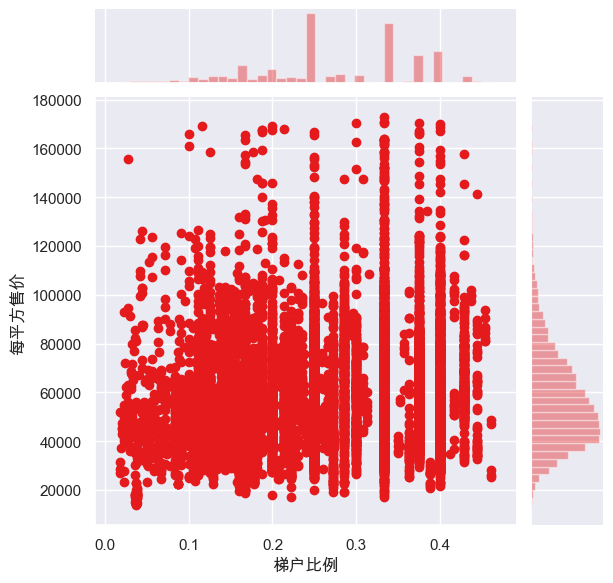

In [44]:
sns.jointplot('梯户比例','每平方售价',data=df[df['梯户比例']<0.5])

**------------------------------------------------------------------------------------------------------------------------------------------------**
<br>
<h5>1.11“配备电梯”</h5>
1.数据集中，约80%有配备电梯。
<br>
2.存在92个缺失值（“暂无数据”），通过对楼层数的判断，填充缺失值，>=7层的，填充为有电梯。
<br>
3.通过图可发现是否配备电梯与价格关系很大。有电梯的房子每平方均价高于没电梯的

In [45]:
df['配备电梯'].value_counts()

有       17337
无        2809
暂无数据       91
Name: 配备电梯, dtype: int64

In [46]:
df['总楼层数'] = df['总楼层数'].astype(int)
df.groupby(['配备电梯'])['总楼层数'].mean() ###查看有无电梯的房子的平均楼层数情况，即没有电梯的，其平均楼层数为6.9层。

配备电梯
无        6.942328
暂无数据    11.945055
有       25.013093
Name: 总楼层数, dtype: float64

In [47]:
df.loc[(df['配备电梯'] == '暂无数据')&(df['总楼层数']>=7),'配备电梯'] = '有'
  

In [48]:
df.loc[(df['配备电梯'] == '暂无数据'),'配备电梯'] = '无'

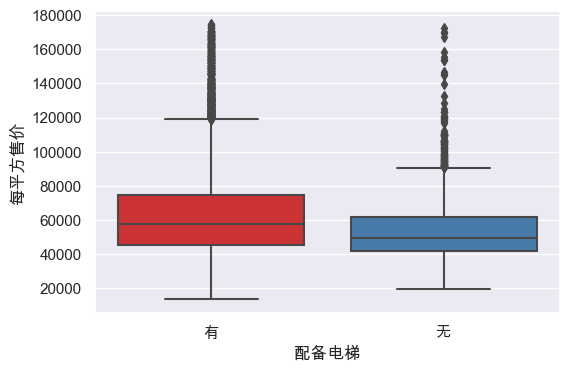

In [49]:
sns.boxplot('配备电梯','每平方售价',data=df)

**------------------------------------------------------------------------------------------------------------------------------------------------**
<br>
<h5>1.12“产权年限”/“房屋用途”</h5>
1.将产权年限与房屋用途两个纬度一起分析。因房屋用途（普通住宅/商务公寓）应与产权年限（70年/50年）是相对应的。
<br>
2.年份存在25个“未知”的缺失值，因该列数据大部分的值为70年，直接填充为70年。
<br>
3.结合两个纬度分析后，发现其与价格影响关系较乱，新增一列纬度“70年的普通住宅”,判断其是否70年的普通住宅。其余纬度删除。

In [50]:
df['产权年限'].value_counts()

70年    19056
50年      900
40年      254
未知        25
30年        2
Name: 产权年限, dtype: int64

In [51]:
df.loc[df['产权年限']=="未知",'产权年限'] = '70年'

In [52]:
df.apply(lambda x:x['房屋用途']+x['产权年限'],axis=1).value_counts()

普通住宅70年     18468
普通住宅50年       428
商务公寓70年       349
商务公寓50年       324
公寓70年         191
商务公寓40年       147
商业办公类50年      104
商业办公类70年       73
商业办公类40年       55
公寓50年          43
普通住宅40年        31
公寓40年          21
普通住宅30年         2
商住两用50年         1
dtype: int64

In [53]:
tmp_df = pd.DataFrame({'a':df.apply(lambda x:x['房屋用途']+x['产权年限'],axis=1),'价格':df['每平方售价']})
tmp_df.groupby(['a'],as_index=False).agg({'价格':['mean','count']})#[['a','价格']].sort_values(('mean'))

a            价格       
                      mean  count
0      公寓40年  41379.047619     21
1      公寓50年  48634.860465     43
2      公寓70年  54162.141361    191
3   商业办公类40年  41805.927273     55
4   商业办公类50年  46580.384615    104
5   商业办公类70年  46736.410959     73
6    商住两用50年  51143.000000      1
7    商务公寓40年  45056.863946    147
8    商务公寓50年  62970.398148    324
9    商务公寓70年  51013.143266    349
10   普通住宅30年  56309.000000      2
11   普通住宅40年  39367.483871     31
12   普通住宅50年  52729.364486    428
13   普通住宅70年  62519.775016  18468

In [54]:
tmp_df = pd.DataFrame({'a':df.apply(lambda x:"70年普通住宅" if (x['房屋用途']+x['产权年限'])=='普通住宅70年' else "非70年普通住宅",axis=1),'价格':df['每平方售价']})
tmp_df.groupby(['a'],as_index=False).agg({'价格':['mean','count']})#[['a','价格']].sort_values(('mean'))

a            价格       
                     mean  count
0   70年普通住宅  62519.775016  18468
1  非70年普通住宅  52369.897117   1769

In [55]:
df['产权情况'] = df.apply(lambda x:"70年普通住宅" if (x['房屋用途']+x['产权年限'])=='普通住宅70年' else "非70年普通住宅",axis=1)
df.drop(['房屋用途','产权年限'],axis=1,inplace=True)

**------------------------------------------------------------------------------------------------------------------------------------------------**
<br>
<h5>1.13“挂牌时间”/“上次交易”/"房屋年限"</h5>
1.将 “挂牌时间/上次交易/房屋年限” 三者结合分析。其主要影响就是税费的问题，是否满5年，满2年，其税费的价格均不同。
<br>
2.对挂牌时间做统计，可以发现，目前链家库存的上架二手房里，于10月份上架的房子是最多的。因数据采集于11月，故11月数据较少。
<br>
3.尝试对“上次交易“这一纬度转为时间格式时，报错，提示数据里有”暂无数据“的行。共计6行缺失，同时房屋年限也是6行，对应统一行。因缺失值较少，直接将缺失的房屋年限填充为“满5年”
<br>
4.舍弃“挂牌时间”/“上次交易”两个纬度，且房屋年限的纬度分布比例差异较大，未满两年的占比太少（2%），将该列的值分为二类，一类“满五年”，一类“未满五年”。
<br>
5.可以看到，满5年和未满5年的平均售价差了约5%（60165与63678)，这也差不多是买房时税费的差价。

In [56]:
df['挂牌时间'] = pd.to_datetime(df['挂牌时间'])#转换为时间格式

In [57]:
(df['房屋年限']=='暂无数据').sum()

6

In [58]:
(df['上次交易']=='暂无数据').sum()

6

In [59]:
df['房屋年限'].value_counts()

满五年     11428
满两年      8341
未满两年      462
暂无数据        6
Name: 房屋年限, dtype: int64

In [60]:
df.loc[df['房屋年限']=='暂无数据','房屋年限'] = '满五年'
df.loc[df['房屋年限'].isin(['未满两年','满两年']),'房屋年限'] = '不满五年'
df['房屋年限'].value_counts()

满五年     11434
不满五年     8803
Name: 房屋年限, dtype: int64

In [61]:
df.groupby(['房屋年限'])['每平方售价'].mean()

房屋年限
不满五年    59479.580598
满五年     63290.082648
Name: 每平方售价, dtype: float64

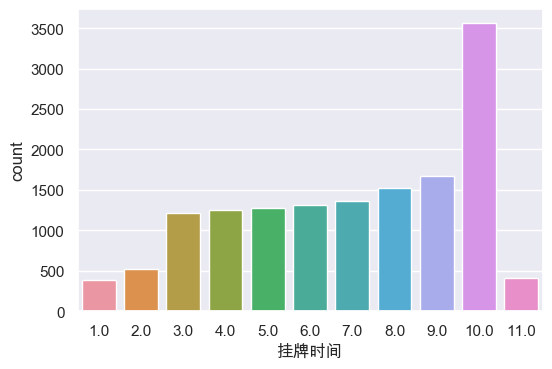

In [62]:
sns.countplot(df['挂牌时间'].apply(lambda x:int(str(x)[5:7]) if str(x)[:4]=='2019' else np.nan)) #查看2019年的每月挂牌房子数量

In [63]:
df.drop(['挂牌时间','上次交易'],axis=1,inplace=True) #删除纬度

**------------------------------------------------------------------------------------------------------------------------------------------------**
<br>
<h5>1.14“抵押信息"</h5>
1.查看可知该列为链家自定义文本列，尝试将文本的关键内容提取作为新的一列。主要提取“有抵押”，“无抵押”2个关键字。
<br>
2.新增一列“抵押情况”，其中“抵押信息”的文本中有“有抵押”关键字的，该列为1，有“无抵押”关键字的，该列为0。
<br>
3.数据统计可得知，有抵押的占了62.6%，无抵押的占了29.6%，还有7.7%的缺失值。
<br>
4.分析新增列“抵押情况”与价格的关系，关联性较低。
<br>

In [64]:
df['抵押信息'][:10]

0               有抵押 200万元 业主实收，客户还款 客户偿还
1                                    无抵押
2                          有抵押 90万元 工商银行
3                    有抵押 220万元 中国银行 客户偿还
4                                    无抵押
5                    有抵押 126万元 建设银行 客户偿还
6    有抵押 230万元 有抵押，抵押金额200王，抵押是招商银行 客户偿还
7                         有抵押 200万元 客户偿还
8                         有抵押 105万元 客户偿还
9                                    无抵押
Name: 抵押信息, dtype: object

In [65]:
df['抵押情况'] = df['抵押信息'].apply(lambda x: 1 if '有抵押' in x else (0 if '无抵押' in x else '暂无数据'))

In [66]:
def countplot_addperc(series):
    ax = sns.countplot(x=series)
    plt.title('Distribution of  Configurations')
    plt.xlabel('Number of Axles')

    total = len(series)
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height()/total)
            x = p.get_x() + p.get_width()/4
            y = p.get_y() + p.get_height()
            ax.annotate(percentage, (x, y))

        
    plt.show()

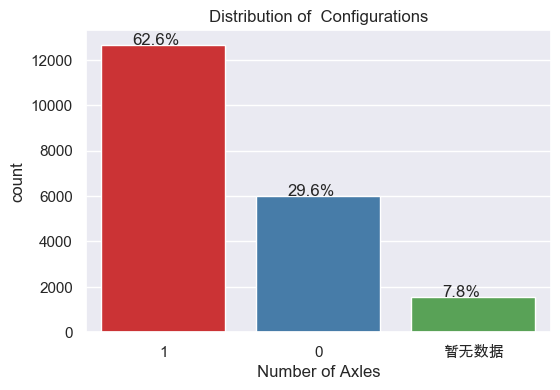

In [67]:
countplot_addperc(df['抵押情况'])

   抵押情况         每平方售价       
                 mean  count
0     0  62646.158439   5996
1     1  61128.435685  12672
2  暂无数据  61830.242192   1569


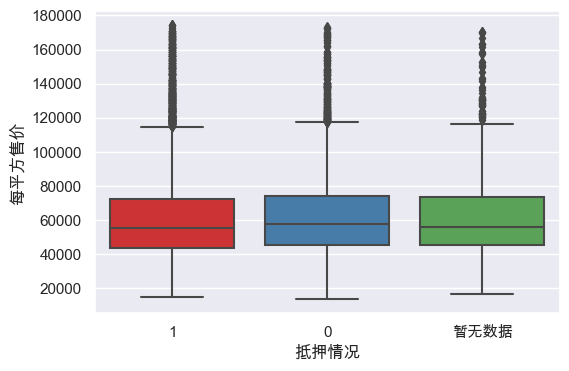

In [68]:
print(df.groupby(['抵押情况'],as_index=False).agg({'每平方售价':['mean','count']}))
sns.boxplot('抵押情况','每平方售价',data=df)#可以看到三者影响不大

**------------------------------------------------------------------------------------------------------------------------------------------------**
<br>
<h5>1.15“建筑年代/类型"</h5>
1.查看可知该纬度的值分为建筑时间和房屋类型，而房屋类型前面的纬度已有，这里通过切片[:4]只取建筑年份
<br>
2.可以看到建筑年代从1980年至2019年均有。将建筑年代转成楼龄，用2019-建筑年份，而建筑年份有些是“未知年建”，需要进一步处理，对于“未知年建“的楼龄，直接填充np.nan
<br>
3.楼龄有375行缺失，即使对小区名字去重后仍有170多个。考虑直接以所在区域（南山/福田/...）的平均楼龄作为缺失值填充。
<br>
4.楼龄与价格有一定的相关性。
<br>

In [69]:
df['建筑年代/类型'].unique()[:5]

array(['2003年建/板塔结合', '2005年建/板塔结合', '1995年建/板塔结合', '2000年建/板塔结合',
       '2002年建/塔楼'], dtype=object)

In [70]:
df['建筑年代/类型'].apply(lambda x :x[:4]).unique()  #取建筑年份

array(['2003', '2005', '1995', '2000', '2002', '1993', '2004', '2013',
       '1984', '1994', '1998', '2014', '2001', '1989', '2008', '1999',
       '2006', '2017', '1997', '1990', '1986', '2015', '1985', '2009',
       '1987', '2007', '2012', '2011', '2010', '1992', '1996', '未知年建',
       '1988', '2016', '1982', '1991', '2018', '1983', '1981', '1980',
       '2019'], dtype=object)

In [71]:
df['楼龄'] = df['建筑年代/类型'].apply(lambda x : (2019 - int(x[:4])) if x[:4]!='未知年建' else np.nan) #新增“楼龄”纬度

In [72]:
print('楼龄缺失行:%s'%df['楼龄'].isnull().sum())
print('根据小区名字去重后楼龄缺失行:%s'%(df.loc[df['楼龄'].isnull(),['小区名字','楼龄']].drop_duplicates('小区名字').shape[0]))

楼龄缺失行:372
根据小区名字去重后楼龄缺失行:171


In [73]:
#用transform函数对所在区域的楼龄平均值对楼龄缺失值进行填充。
df['楼龄'] = df.groupby("所在区域")["楼龄"].transform(lambda x: x.fillna(x.median())) 

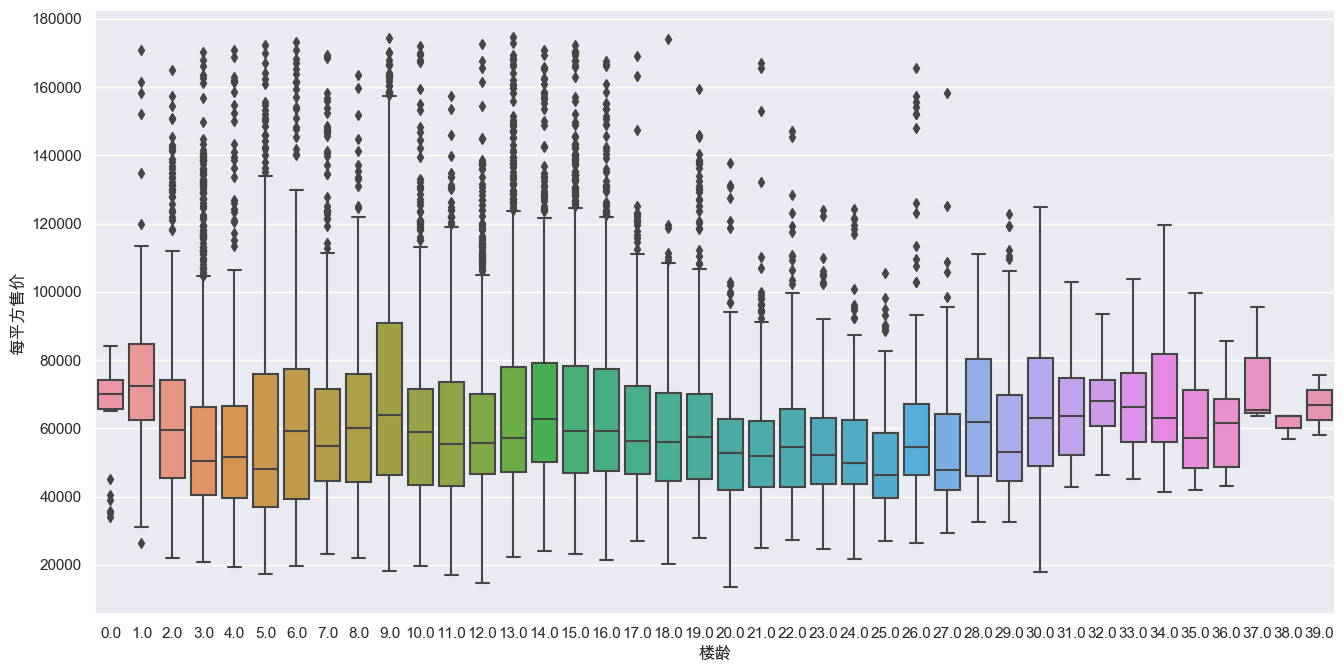

In [74]:
#查看楼龄与每平方售价的箱型图，发现关联性不大，这与我们的常识违背。
plt.figure(figsize=(16,8))
sns.boxplot('楼龄','每平方售价',data=df)

/Users/para/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


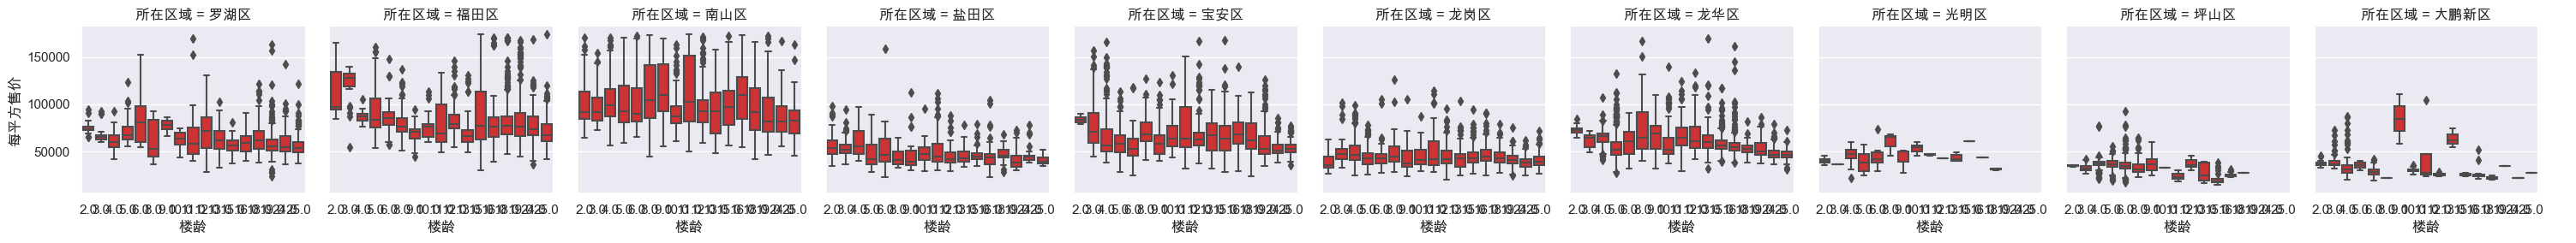

In [75]:
#查看各个区，楼龄与每平方售价的关系
g = sns.FacetGrid(df, col="所在区域")
g.map(sns.boxplot,'楼龄','每平方售价')
g.add_legend()

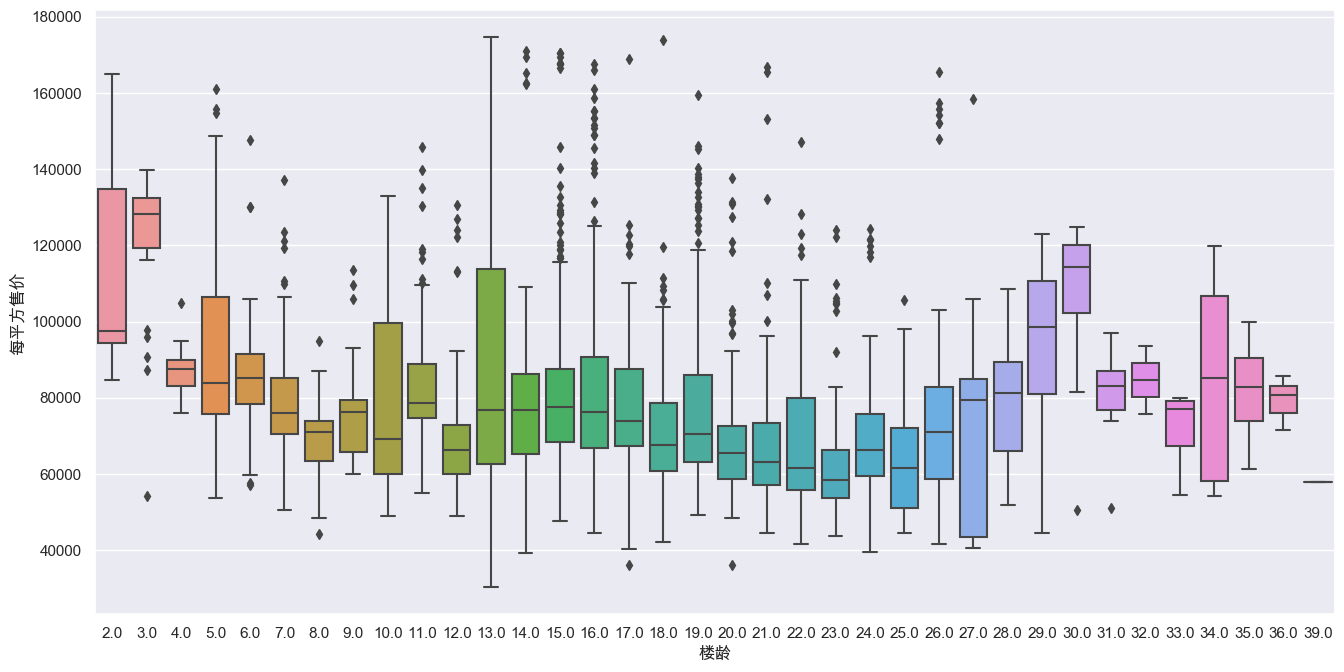

In [76]:
#单独查看福田区
plt.figure(figsize=(16,8))
sns.boxplot('楼龄','每平方售价',data=df.loc[df['所在区域']=='福田区',:])

In [77]:
df.drop('建筑年代/类型',axis=1,inplace=True)

**------------------------------------------------------------------------------------------------------------------------------------------------**
<br>
<h5>1.16“所在区域"</h5>
1.因链家数据爬虫原因，几个主要区域的房子数量是差不多相同的。
<br>
2.查看不同区域的售价情况，可以看到有很明显的差异，这与我们假设一致。该项会显然显著影响价格。
<br>



In [78]:
df['所在区域'].value_counts()

福田区     2978
龙岗区     2975
罗湖区     2974
宝安区     2964
龙华区     2954
南山区     2906
盐田区     1231
坪山区      749
大鹏新区     319
光明区      187
Name: 所在区域, dtype: int64

In [79]:
df.groupby('所在区域')['每平方售价'].mean().sort_values()

所在区域
大鹏新区    33556.040752
坪山区     34300.204272
光明区     41657.775401
龙岗区     43736.240672
盐田区     47613.762794
龙华区     56886.332769
罗湖区     56902.545057
宝安区     61390.953441
福田区     77890.086635
南山区     90555.609429
Name: 每平方售价, dtype: float64

**------------------------------------------------------------------------------------------------------------------------------------------------**
<br>
<h5>1.17“近30日看房人数"</h5>
1.在爬虫的数据中，有提取到一个纬度，就是每个房子的近30日看房人数。可以做个简单分析。
<br>
2.可以看到，大部分房子的看房人数集中在0到1次，当然也甚至有超过30次的房子。
<br>
3.进一步按区间分析，可以看到，一次都没人看的房子占了27.3%，1次的占了19.5%，1到7次的的房子占了36.5%。
<br>
4.哪个区的房子每月看房平均人数最多呢,可以看到是龙岗区，均值接近6.
<br>
5.相应的，在房子其余属性一致的情况下，一个房子带看人数越多，可以假设房子的性价比越高，价格越优惠，该纬度暂作保留。

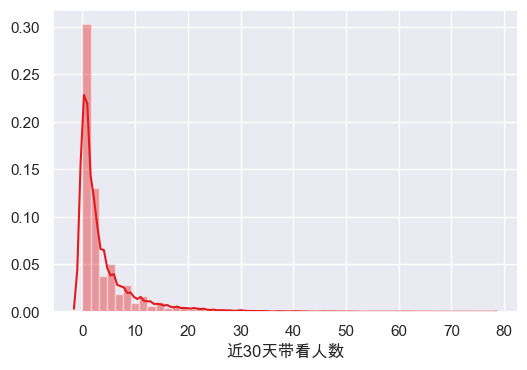

In [80]:
sns.distplot(df['近30天带看人数'])

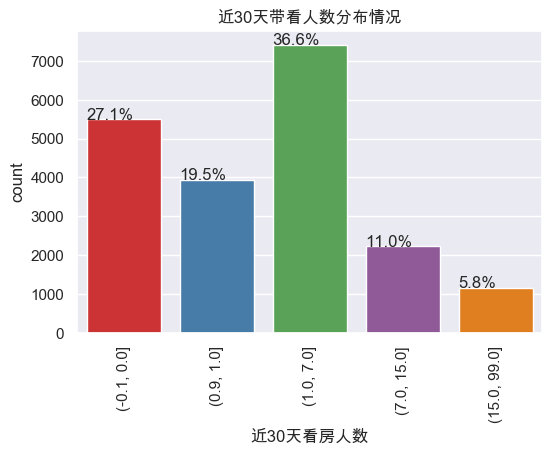

In [81]:
bins = pd.IntervalIndex.from_tuples([(-0.1, 0), (0.9, 1), (1, 7),(7, 15),(15, 99)])
ax = sns.countplot(pd.cut(df['近30天带看人数'],bins=bins),palette='Set1')
plt.xticks(rotation='vertical')
plt.title('近30天带看人数分布情况')
plt.xlabel('近30天看房人数')

total = len(pd.cut(df['近30天带看人数'],20))
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() #+ p.get_width()
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y))


In [82]:
#下面看看看房超过每月30次频率的房子。共计259个，笋盘列表。
pd.set_option('max_colwidth',60)#该代码主要是让字段完全显示，max_colwidth即为每个单元格可显示字段，设置为60，才能全显示url链接。
df.loc[df['近30天带看人数']>=30,['url','挂牌时间','每平方售价','所在区域','总价格','近30天带看人数']].sort_values('近30天带看人数',ascending=False)

/Users/para/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,url,挂牌时间,每平方售价,所在区域,总价格,近30天带看人数
10833,https://sz.lianjia.com/ershoufang/105102359608.html,NaN,68193,宝安区,295.0,77
3119,https://sz.lianjia.com/ershoufang/105102861837.html,NaN,68660,福田区,395.0,72
34,https://sz.lianjia.com/ershoufang/105103129644.html,NaN,47972,罗湖区,188.0,70
13337,https://sz.lianjia.com/ershoufang/105102164461.html,NaN,38519,龙岗区,208.0,66
13644,https://sz.lianjia.com/ershoufang/105103063937.html,NaN,40239,龙岗区,249.8,65
10257,https://sz.lianjia.com/ershoufang/105102924300.html,NaN,50152,宝安区,448.0,64
6035,https://sz.lianjia.com/ershoufang/105101455718.html,NaN,73210,南山区,555.0,62
13385,https://sz.lianjia.com/ershoufang/105103191989.html,NaN,37796,龙岗区,273.0,62
5992,https://sz.lianjia.com/ershoufang/105102392642.html,NaN,117439,南山区,1460.0,62
1318,https://sz.lianjia.com/ershoufang/105102988706.html,NaN,62413,罗湖区,355.0,61


In [83]:
df.groupby(['所在区域'])['近30天带看人数'].mean().sort_values()

所在区域
大鹏新区    0.454545
盐田区     1.737612
光明区     2.299465
坪山区     2.785047
龙华区     3.142857
罗湖区     3.147949
福田区     4.011753
南山区     4.717825
宝安区     5.630904
龙岗区     5.987899
Name: 近30天带看人数, dtype: float64

相应的，在房子其余属性一致的情况下，一个房子带看人数越多，可以假设房子的性价比越高，价格越优惠，该纬度暂作保留。

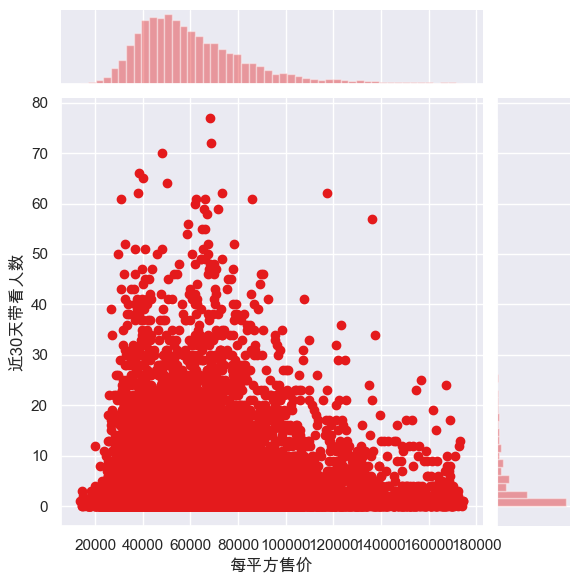

In [84]:
sns.jointplot('每平方售价','近30天带看人数',data=df)

**------------------------------------------------------------------------------------------------------------------------------------------------**
<br>
<h5>1.18“房本备件"/"交易权属"/"url"/“房间数”/“楼层情况“/”朝向“/”装修“/”平方米“</h5>
1.“房本备件”未上传的仅6户，比例差距过大，可直接删除。
<br>
2.“交易权属”仅有一个值，删除。
<br>
3.“url”为房子链家链接，可删除。
<br>
4.“房协编码”为房子的唯一标示号，与价格无关，直接删除。
<br>
5.“房间数”/“楼层情况“/”朝向“/”装修“/”平方米“--- 重复项，直接删除。

In [85]:
df['房本备件'].value_counts()

已上传房本照片    20231
未上传房本照片        6
Name: 房本备件, dtype: int64

In [86]:
df['交易权属'].value_counts()

商品房    20237
Name: 交易权属, dtype: int64

In [87]:
df.drop(['交易权属','url','房本备件','房间数','楼层情况','朝向','装修','平方米'],axis=1,inplace=True)

**------------------------------------------------------------------------------------------------------------------------------------------------**
<br>
<h5>1.19"经度“/”纬度“</h5>
1.在数据源中，房子所处的经纬度为其区域+小区名字通过调用百度地图api所得到的数值
<br>
2.按照我们假设，地理位置对房子对价格会是一个显著的影响因素，这里我们新增一个纬度，通过计算房子坐标距离最近地铁站的位置距离，来判断房子好坏。
<br>
3.我们假设，距离地铁站超过1km的，则认为不靠近地铁。新增一个纬度“是否靠近地铁”。分别用数值1和0代表靠近/不靠近。
<br>
4.可发现新增的纬度与价格的相关性很强。


<p>#metro.xlsx为所有的深圳地铁站经纬度坐标，来源：百度地图。</p>

In [88]:
#根据经纬度获取最近地铁距离，用列latest表示，单位为千米
metro=pd.read_excel(r'metro.xlsx')

def getDistance(lat1, lng1, lat2, lng2): #计算两个经纬度之间的距离
    import math
    EARTH_REDIUS = 6378.137
    def rad(d):
        return d * math.pi / 180.0
    radLat1 = rad(lat1)
    radLat2 = rad(lat2)
    a = radLat1 - radLat2
    b = rad(lng1) - rad(lng2)
    s = 2 * math.asin(math.sqrt(math.pow(math.sin(a/2), 2) + math.cos(radLat1) * math.cos(radLat2) * math.pow(math.sin(b/2), 2)))
    s = s * EARTH_REDIUS
    return s

def littlestat(list):
    metro['distance']=metro.apply(lambda x:getDistance(list[0],list[1],x['weight'],x['long']),axis=1)
    return metro['distance'].min()

df['latest']=df.apply(lambda x:littlestat([x['纬度'],x['经度']]),axis=1)

In [89]:
df['是否靠近地铁']=df['latest'].apply(lambda x:"否" if x>1 else "是") #假设直线距离>1km，则认为不靠近地铁。
df.drop(['经度','纬度','latest'],axis=1,inplace=True)

In [90]:
df['是否靠近地铁'].value_counts(0)

是    12501
否     7736
Name: 是否靠近地铁, dtype: int64

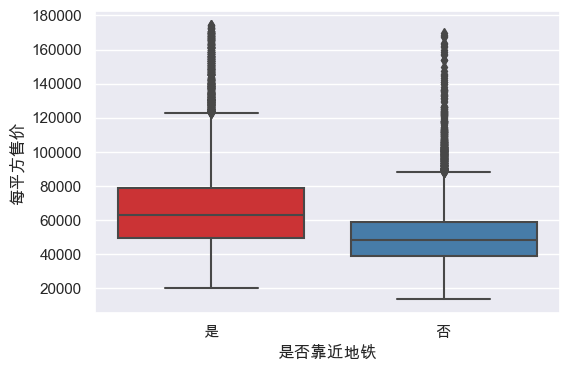

In [91]:
sns.boxplot('是否靠近地铁','每平方售价',data=df) #可以明显看到，靠近地铁的价格明显更高

**------------------------------------------------------------------------------------------------------------------------------------------------**
<br>
<h5>1.20"小区名字“/”title1“/"title2"/"key"/"id"/"总价格"/产权所属"</h5>
1.小区名字与价格暂无相关性比较，删除。
<br>
2.title1为房屋的文本介绍，暂不考虑。
<br>
3.title2为经纪人的房屋宣传文本，暂不考虑。
<br>
4.key / id为唯一标识，删除。
<br>
5.本次数据分析为预测各个因素对每平方价格的影响，暂时删除“总价格”纬度。
<br>
6.产权所属结合实际，与价格的关系影响不大。且数据也呈现出这点，删除。

非共有    17567
共有      2670
Name: 产权所属, dtype: int64


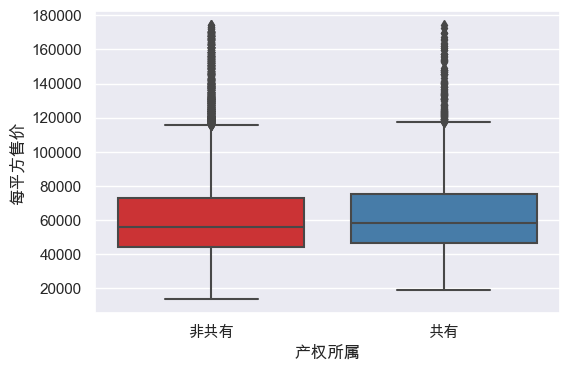

In [92]:
print(df['产权所属'].value_counts())
sns.boxplot('产权所属','每平方售价',data=df)

In [93]:
df['title1'][:5]

0    ['客厅', '22.96平米', '西', '普通窗', '卧室A', '8.89平米', '无', '未知窗...
1    ['客厅', '17.36平米', '北', '普通窗', '卧室', '6.8平米', '无', '未知窗户类...
2    ['客厅', '21.12平米', '北', '普通窗', '卧室', '10.83平米', '无', '未知窗...
3    ['客厅', '22.27平米', '北', '普通窗', '餐厅', '9.31平米', '无', '普通窗'...
4    ['客厅', '17.07平米', '南', '普通窗', '卧室A', '7.89平米', '无', '未知窗...
Name: title1, dtype: object

In [94]:
df['title2'][:5]

0          ['嘉宝田花园两房', '朝南楼层适中', '诚心出售']
1    ['此房红本在手', '满五唯一', '精装修', '业主诚心放卖']
2       ['罗湖2005年电梯两房', '满五年精装', '户型方正']
3              ['此房户型方正，大三房单价低，近地铁出行方便']
4              ['大社区，南向两房，红本在手满五唯一，税费少']
Name: title2, dtype: object

In [95]:
df.drop(['小区名字','title1','title2','key','id','总价格','产权所属'],axis=1,inplace=True)

<h3>总结</h3>
<p>房屋户型：我们将房屋户型转成了4个纬度，分别是“室”，“厅”，“厨”，“卫”。</p>
<p>所在楼层：我们拆分成了2个纬度，分别是"所处楼层高度",“总楼层数”。</p>
<p>建筑面积：将str的数据类型转换成了float数据类型，如67.24㎡>>67.24。</p>
<p>户型结构：无变化</p>
<p>套内面积：缺失值过多，且该项与建筑面积强相关，drop掉。</p>
<p>建筑类型：保留</p>
<p>房屋朝向：删除。</p>
<p>建筑结构：保留</p>
<p>装修情况：保留</p>
<p>梯户比例：将str的数据类型转换成了float数据类型，如三梯八户=3/8。</p>
<p>配备电梯：保留，同时将缺失值按照楼层高度进行猜测填充。</p>
<p>产权年限：与房屋用途高度重叠，drop掉。</p>
<p>挂牌时间/上次交易：转换为一个纬度“买房到卖房天数差”，而该纬度与“房屋年限”相关性很强，drop掉。</p>
<p>房屋用途：保留，转换成了“是否普通住宅”的二分类纬度。</p>
<p>房屋年限：保留，取值仅保留“满5年”，“不满5年”。</p>
<p>产权所属/房本备件/房协编码/url：删除。</p>
<p>抵押信息：删除。</p>
<p>房间数/楼层情况/朝向/装修：删除，重复字段。</p>
<p>建筑年代/类型：转换成“楼龄”。</p>
<p>所在区域：保留。</p>
<p>近30天带看人数：保留。</p>
<p>小区名字：删除。</p>
<p>经度/纬度：转换成“是否靠近地铁”。</p>

<h4>下面查看清洗后的数据分布情况</h4>
1."总楼层数"因为已有“总楼层数区间”的纬度，该列删除。
<br>
2.剩余的纬度中，共有10个连续变量，11个离散变量。
<br>
3.将二分类的离散变量的取值转为0和1(sklearn.preprocessing.LabelEncoder)，将多分类的离散变量用one-hot编码(pd.get_dummies)表示。

In [96]:
df.head()

,建筑面积,户型结构,建筑类型,建筑结构,装修情况,梯户比例,配备电梯,房屋年限,抵押信息,所在区域,近30天带看人数,每平方售价,室,厅,厨房,卫,所处楼层高度,总楼层数,总楼层数区间,产权情况,抵押情况,楼龄,是否靠近地铁
0,67.24,平层,板塔结合,钢混结构,简装,0.375000,有,不满五年,有抵押 200万元 业主实收，客户还款 客户偿还,罗湖区,2,62463,2,1,1,1,高,25,2,70年普通住宅,1,16.0,是
1,46.19,平层,板塔结合,钢混结构,精装,0.214286,有,满五年,无抵押,罗湖区,7,53692,1,1,1,1,低,33,2,70年普通住宅,0,14.0,是
2,67.55,平层,板塔结合,钢混结构,精装,0.250000,有,满五年,有抵押 90万元 工商银行,罗湖区,2,42191,2,1,1,1,高,26,2,70年普通住宅,1,14.0,是
3,91.05,平层,板塔结合,钢混结构,精装,0.375000,有,不满五年,有抵押 220万元 中国银行 客户偿还,罗湖区,18,34597,3,1,1,1,低,30,2,70年普通住宅,1,24.0,是
4,59.54,平层,板塔结合,钢混结构,精装,0.250000,有,满五年,无抵押,罗湖区,23,55090,2,2,1,1,中,16,1,70年普通住宅,0,19.0,否


In [97]:
df.drop(['总楼层数','抵押信息'],axis=1,inplace=True)

In [98]:
resumetable(df)

Dataset Shape: (20237, 21)
户型结构:['平层' '暂无数据' '复式' '错层' '跃层']
建筑类型:['板塔结合' '塔楼' '板楼' '暂无数据' '平房']
建筑结构:['钢混结构' '框架结构' '砖混结构' '钢结构' '混合结构' '未知结构' '砖木结构']
装修情况:['简装' '精装' '其他' '毛坯']
配备电梯:['有' '无']
房屋年限:['不满五年' '满五年']
所在区域:['罗湖区' '福田区' '南山区' '盐田区' '宝安区' '龙岗区' '龙华区' '光明区' '坪山区' '大鹏新区']
厅:[1 2 0 3 5 4]
厨房:[1 0 2 3 6]
卫:[1 2 3 6 5 0 4 7 9]
所处楼层高度:['高' '低' '中']
总楼层数区间:[2 1 3 4]
产权情况:['70年普通住宅' '非70年普通住宅']
抵押情况:[1 0 '暂无数据']
是否靠近地铁:['是' '否']



,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,建筑面积,float64,0,9143,67.24,46.19,67.55,12.69
1,户型结构,object,0,5,平层,平层,平层,0.88
2,建筑类型,object,0,5,板塔结合,板塔结合,板塔结合,1.34
3,建筑结构,object,0,7,钢混结构,钢混结构,钢混结构,0.51
4,装修情况,object,0,4,简装,精装,精装,1.55
5,梯户比例,float64,0,162,0.375,0.214286,0.25,4.18
6,配备电梯,object,0,2,有,有,有,0.58
7,房屋年限,object,0,2,不满五年,满五年,满五年,0.99
8,所在区域,object,0,10,罗湖区,罗湖区,罗湖区,3.01
9,近30天带看人数,int64,0,68,2,7,2,3.55


In [99]:
#2个取值的离散变量转成分类变量
def discrete2Categorica(df):
    from sklearn.preprocessing import LabelEncoder
    le_count = 0
    le = LabelEncoder()
    lists = []
    # Iterate through the columns
    for col in df:
        if df[col].dtype == 'object':

            # If 2 or fewer unique categories
            if len(list(df[col].unique())) <= 2:
                print(col)
                # Train on the training data
                le.fit(df[col])
                # Transform both training and testing data
                df[col] = le.transform(df[col])
                lists.append(col)
                le_count += 1
    print('%d columns were label encoded.' % le_count)
    return df,lists

discrete2Categorica(df)

配备电梯
房屋年限
产权情况
是否靠近地铁
4 columns were label encoded.


(         建筑面积  户型结构  建筑类型  建筑结构 装修情况      梯户比例  配备电梯  房屋年限  所在区域  近30天带看人数  \
 0       67.24    平层  板塔结合  钢混结构   简装  0.375000     1     0   罗湖区         2   
 1       46.19    平层  板塔结合  钢混结构   精装  0.214286     1     1   罗湖区         7   
 2       67.55    平层  板塔结合  钢混结构   精装  0.250000     1     1   罗湖区         2   
 3       91.05    平层  板塔结合  钢混结构   精装  0.375000     1     0   罗湖区        18   
 4       59.54    平层  板塔结合  钢混结构   精装  0.250000     1     1   罗湖区        23   
 5       37.28    平层  板塔结合  钢混结构   简装  0.230769     1     0   罗湖区         7   
 6       69.30  暂无数据  板塔结合  钢混结构   精装  0.250000     1     0   罗湖区         9   
 7       83.84    平层  板塔结合  钢混结构   精装  0.300000     1     1   罗湖区         0   
 8       49.47    平层    塔楼  钢混结构   精装  0.187500     1     1   罗湖区        21   
 9       75.83    平层  板塔结合  钢混结构   简装  0.375000     1     1   罗湖区        14   
 10      60.53    平层  板塔结合  钢混结构   简装  0.200000     1     1   罗湖区        30   
 11      86.28    平层  板塔结合  钢混结构   简装  0.250000     

In [100]:
df.head()

,建筑面积,户型结构,建筑类型,建筑结构,装修情况,梯户比例,配备电梯,房屋年限,所在区域,近30天带看人数,每平方售价,室,厅,厨房,卫,所处楼层高度,总楼层数区间,产权情况,抵押情况,楼龄,是否靠近地铁
0,67.24,平层,板塔结合,钢混结构,简装,0.375000,1,0,罗湖区,2,62463,2,1,1,1,高,2,0,1,16.0,1
1,46.19,平层,板塔结合,钢混结构,精装,0.214286,1,1,罗湖区,7,53692,1,1,1,1,低,2,0,0,14.0,1
2,67.55,平层,板塔结合,钢混结构,精装,0.250000,1,1,罗湖区,2,42191,2,1,1,1,高,2,0,1,14.0,1
3,91.05,平层,板塔结合,钢混结构,精装,0.375000,1,0,罗湖区,18,34597,3,1,1,1,低,2,0,1,24.0,1
4,59.54,平层,板塔结合,钢混结构,精装,0.250000,1,1,罗湖区,23,55090,2,2,1,1,中,1,0,0,19.0,0


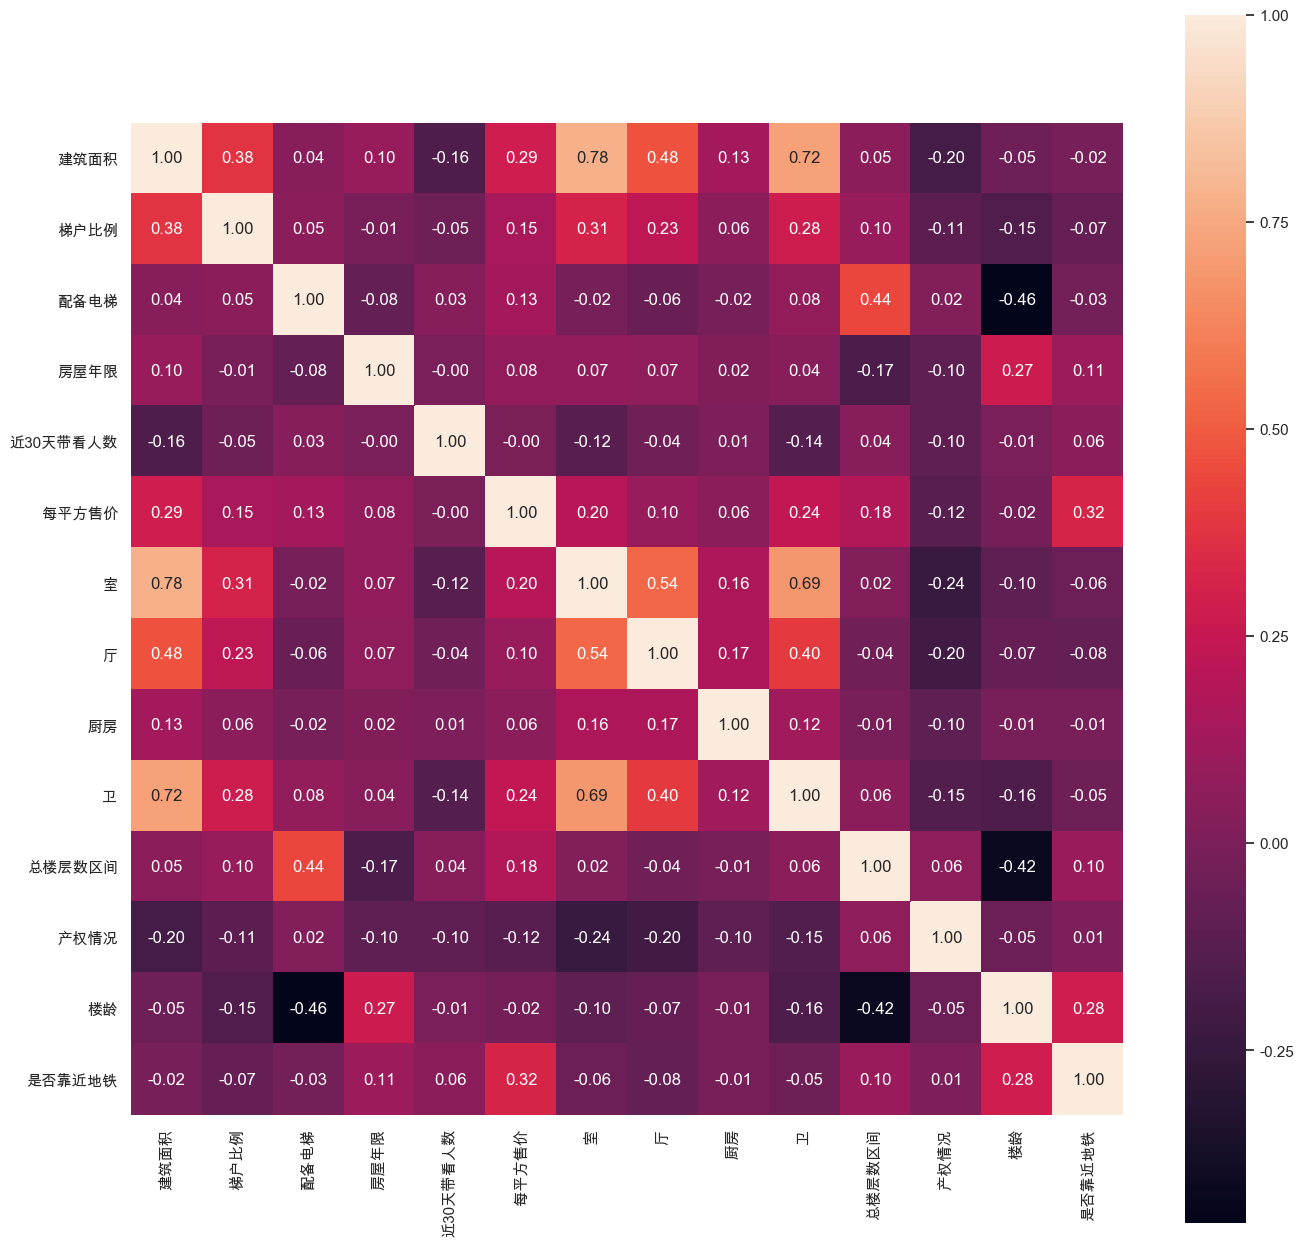

In [101]:
#查看热力图
plt.figure(figsize=(16,16))
sns.heatmap(df.corr(),cbar=True, annot=True, square=True,fmt='.2f')

In [102]:
#one-hot
learn_data = pd.get_dummies(df)

In [103]:
learn_data.head(3)

,建筑面积,梯户比例,配备电梯,房屋年限,近30天带看人数,每平方售价,室,厅,厨房,卫,总楼层数区间,产权情况,楼龄,是否靠近地铁,户型结构_复式,户型结构_平层,户型结构_暂无数据,户型结构_跃层,户型结构_错层,建筑类型_塔楼,建筑类型_平房,建筑类型_暂无数据,建筑类型_板塔结合,建筑类型_板楼,建筑结构_未知结构,建筑结构_框架结构,建筑结构_混合结构,建筑结构_砖木结构,建筑结构_砖混结构,建筑结构_钢混结构,建筑结构_钢结构,装修情况_其他,装修情况_毛坯,装修情况_简装,装修情况_精装,所在区域_光明区,所在区域_南山区,所在区域_坪山区,所在区域_大鹏新区,所在区域_宝安区,所在区域_盐田区,所在区域_福田区,所在区域_罗湖区,所在区域_龙华区,所在区域_龙岗区,所处楼层高度_中,所处楼层高度_低,所处楼层高度_高,抵押情况_0,抵押情况_1,抵押情况_暂无数据
0,67.24,0.375000,1,0,2,62463,2,1,1,1,2,0,16.0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
1,46.19,0.214286,1,1,7,53692,1,1,1,1,2,0,14.0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
2,67.55,0.250000,1,1,2,42191,2,1,1,1,2,0,14.0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0


<h4>xgboost建模</h4>
本数据集选用xgboost的机器算法

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [105]:
x = learn_data.drop('每平方售价',axis=1)
y = learn_data['每平方售价']

In [106]:
x_st = StandardScaler().fit_transform(x)

In [107]:
x_train,x_test,y_train,y_test = train_test_split(x_st,y,test_size=0.2)

In [109]:
import xgboost as xgb

regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.05,
                 max_depth=6,
                 min_child_weight=1.5,
                 n_estimators=5000,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=0)

regr.fit(x_train,y_train)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = regr.predict(x_test)
print('均方根误差:',metrics.mean_squared_error(y_test,y_pred)**0.5)
print('可释方差分数',metrics.explained_variance_score(y_test,y_pred))
print('绝对值误差',metrics.mean_absolute_error(y_test,y_pred))
print('r2系数',metrics.r2_score(y_test,y_pred))

[13:23:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
均方根误差: 12713.481509510451
可释方差分数 0.734573045205748
绝对值误差 8764.471644465631
r2系数 0.7342148825670209


In [ ]:
plt.figure(dpi=100,figsize=(500,8))
plt.plot(range(len(y_pred)), y_pred, 'b', label="predict")
plt.plot(range(len(y_test)), y_test, 'r', label="real")